In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import lib.vgg_nst as vgg_nst

# Get Model

In [2]:
# neural style transfer output

content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]

In [3]:
model = vgg_nst.get_model(content_layers, style_layers)

# Load image

In [4]:
im = Image.open("./img/2valk.jpg")

# resize
new_im = im.resize((np.array(im.size)//4).astype(int))
arr_im = np.array(new_im)

In [5]:
arr_im.shape

(454, 512, 3)

# Image Preprocessing

In [6]:
def preprocess_image(image_arr):
    # input shape (h, w, chan)
    
    # (1 sample, h, w, chan)
    img = tf.convert_to_tensor(np.expand_dims(image_arr, axis=0), dtype=tf.float32)
    return img

In [7]:
tensor_img = preprocess_image(arr_im)

In [8]:
tensor_img.shape

TensorShape([1, 454, 512, 3])

In [9]:
def deprocess_image(image_tensor):
    # tensor shape (1 sample, h, w, chan)
    img = np.array(image_tensor.numpy().astype(np.int32))
    return img[0]

# VGG-19 Image RE-creation

## Random Image

In [10]:
random_img = np.random.randint(0, 255, arr_im.shape)
generated_img_tensor = tf.Variable(preprocess_image(random_img))

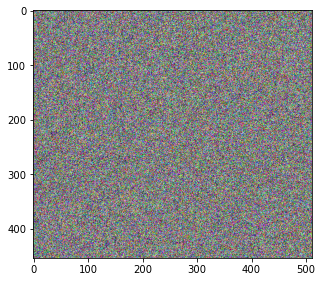

In [11]:
fig = plt.figure(figsize=(5, 5))
plt.imshow(deprocess_image(generated_img_tensor))
plt.show()

## Content Loss

In [12]:
def compute_content_loss(base_feature, generated_feature):
    return tf.reduce_sum(tf.square(generated_feature - base_feature))

In [13]:
content_feature = 'block1_conv1'

base_feature = model(preprocess_image(arr_im))[content_feature]
generated_feature = model(preprocess_image(random_img))[content_feature]

In [14]:
compute_content_loss(base_feature, base_feature)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [15]:
compute_content_loss(base_feature, generated_feature)

<tf.Tensor: shape=(), dtype=float32, numpy=59665916000.0>

# compute gradient

In [16]:
@tf.function
def compute_loss_grads(base_image, generated_image):
    base_feature = model(base_image)[content_feature]
    generated_feature = model(generated_image)[content_feature]
    
    with tf.GradientTape() as tape:
#         tape.watch(generated_image)
        loss = compute_content_loss(base_feature, generated_feature)
    grads = tape.gradient(loss, generated_image)
    return loss, grads

In [17]:
compute_loss_grads(tensor_img, generated_img_tensor)

(<tf.Tensor: shape=(), dtype=float32, numpy=59665916000.0>, None)

## Optimizer

In [18]:
opt = tf.keras.optimizers.SGD(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=20.0, decay_steps=100, decay_rate=0.9
    )
)

In [19]:
base_img = preprocess_image(arr_im)
generated_img = tf.Variable(preprocess_image(random_img))

In [20]:
iterations = 1000
content_feature = 'block1_conv1'

for i in range(1, iterations+1):
    
    loss, grads = compute_loss_grads(base_img, generated_img)
    opt.apply_gradients([(grads, generated_img)])
    
    if i % 100 == 0 or i == 1:
        print(f"iteration: {i} \t, loss: {loss:.2f}")
        generated_img_de = deprocess_image(generated_img)
        fig = plt.figure(figsize=(5, 5))
        plt.title(f"iteration: {i}")
        plt.imshow(generated_img_de)
        plt.show()

ValueError: No gradients provided for any variable: ['Variable:0'].